In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-05-29 10:09:35.645401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Load the data
df = pd.read_csv("/Users/user/Documents/datasets/creditcard.csv")

std_scaler = StandardScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount'], inplace=True, axis = 1)
df.drop(['Time'], inplace=True, axis = 1)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2, random_state=42)

In [3]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.313289,1.022112
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.169717,0.470837
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.305292,1.152945
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.116306,-0.024087
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.250239,-0.256040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,0.079128,...,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,-0.345313,-0.404225
259178,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,-0.654029,...,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,0.003520,1.351627
131932,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,-0.212753,...,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,-0.337477,-0.316266
146867,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,-0.027572,...,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,-0.349231,-0.144939


In [4]:
# Create a Variational Autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)

z_mean = Dense(encoding_dim, name='z_mean')(encoder)
z_log_var = Dense(encoding_dim, name='z_log_var')(encoder)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])

decoder = Dense(int(encoding_dim / 2), activation='tanh')(z)
decoder = Dense(input_dim, activation='relu')(decoder)

vae = Model(inputs=input_layer, outputs=decoder)

# Compute the VAE loss
reconstruction_loss = tf.keras.losses.mean_squared_error(input_layer, decoder)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * tf.keras.backend.sum(kl_loss, axis=-1)
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

# Train the VAE on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)
vae.compile(optimizer='adam')
history = vae.fit(X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, None)) # epoch = 100

# Generate synthetic fraud transactions using the trained VAE
X_fraud = X_train[y_train == 1]
synthetic_fraud = vae.predict(X_fraud)

# Add noise to the synthetic fraud transactions
noise_factor = 0.2
synthetic_fraud_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_noisy))
######################################################
# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

2023-05-29 10:09:40.528734: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/bias/Assign' id:161 op device:{requested: '', assigned: ''} def:{{{node dense_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/bias, dense_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-29 10:09:40.548510: W tensorflow/c/c_api.cc:300] Operation '{name:'Mean/reduction_indices' id:169 op device:{requested: '', assigned: ''} def:{{{node Mean/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes aft

Train on 181960 samples, validate on 45491 samples
Epoch 1/100
  1952/181960 [..............................] - ETA: 18s - loss: 2.4948  

2023-05-29 10:09:40.896637: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:516 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


181568/181960 [============================>.] - ETA: 0s - loss: 1.0731

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-29 10:09:45.869494: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/AddN' id:203 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](dense/ActivityRegularizer/truediv, Mean_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


181960/181960 [==============================] - 6s 31us/sample - loss: 1.0728 - val_loss: 1.0722
Epoch 2/100
181960/181960 [==============================] - 5s 30us/sample - loss: 1.0478 - val_loss: 1.0716
Epoch 3/100
181960/181960 [==============================] - 5s 30us/sample - loss: 1.0474 - val_loss: 1.0715
Epoch 4/100
181960/181960 [==============================] - 5s 29us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 5/100
181960/181960 [==============================] - 5s 30us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 6/100
181960/181960 [==============================] - 5s 30us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 7/100
181960/181960 [==============================] - 5s 30us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 8/100
181960/181960 [==============================] - 6s 30us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 9/100
181960/181960 [==============================] - 6s 31us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 10/100
181960/18

Epoch 75/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 76/100
181960/181960 [==============================] - 5s 26us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 77/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 78/100
181960/181960 [==============================] - 5s 26us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 79/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 80/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 81/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 82/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
Epoch 83/100
181960/181960 [==============================] - 5s 25us/sample - loss: 1.0473 - val_loss: 1.0715
E

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-29 10:18:25.142400: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Relu' id:167 op device:{requested: '', assigned: ''} def:{{{node dense_3/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [5]:
# Apply SMOTE Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

# Fit the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', cm)
##################################

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9995611109160493
Confusion matrix:
 [[56855     9]
 [   16    82]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


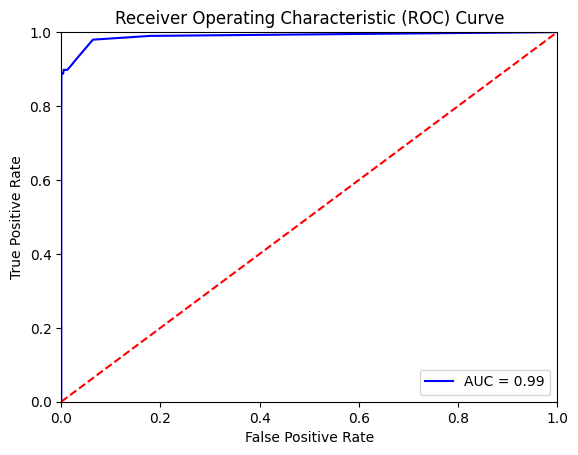

Accuracy: 0.999561
F1-score:  0.8677248677248677
Precision:  0.9010989010989011
Recall:  0.8367346938775511
Specificity:  0.9998417276308385
Sensitivity:  0.8367346938775511
AUC:  0.9895899130614543
Matthews correlation coefficient: 0.868102950679163


In [6]:
print(classification_report(y_test, y_pred))

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: %f" % accuracy)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

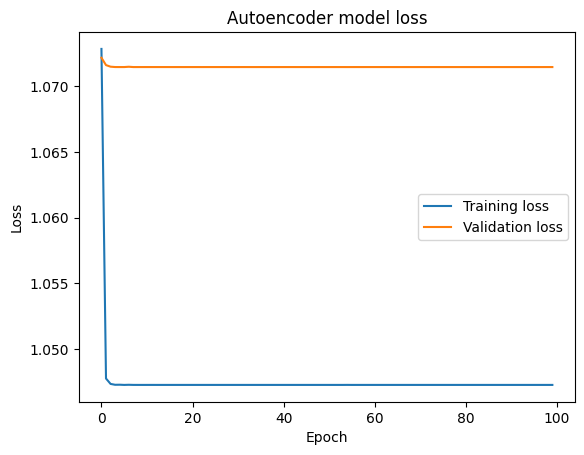

In [7]:
# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()